In [1]:
import numpy as np
import tensorflow as tf
print(tf.test.gpu_device_name())

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, concatenate, Reshape, Activation, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from sklearn.metrics import log_loss

from keras.preprocessing.image import ImageDataGenerator

from keras import optimizers

/device:GPU:0


In [2]:
def conv2d_bn(x, n_filters, rows, cols,
              padding='same', subsample=(1, 1)):
  x = Conv2D(n_filters, (rows, cols), strides=subsample, padding=padding, activation='relu')(x)
  x = BatchNormalization()(x)
  return x

In [3]:
def inception_a(input):
  branch_0 = conv2d_bn(input, 96, 1, 1)

  branch_1 = conv2d_bn(input, 64, 1, 1)
  branch_1 = conv2d_bn(branch_1, 96, 3, 3)

  branch_2 = conv2d_bn(input, 64, 1, 1)
  branch_2 = conv2d_bn(branch_2, 96, 3, 3)
  branch_2 = conv2d_bn(branch_2, 96, 3, 3)

  branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
  branch_3 = conv2d_bn(branch_3, 96, 1, 1)

  x = concatenate([branch_0, branch_1, branch_2, branch_3])
  return x

In [4]:
def reduction_a(input):
  branch_0 = conv2d_bn(input, 384, 3, 3, subsample=(2,2), padding='valid')

  branch_1 = conv2d_bn(input, 192, 1, 1)
  branch_1 = conv2d_bn(branch_1, 224, 3, 3)
  branch_1 = conv2d_bn(branch_1, 256, 3, 3, subsample=(2,2), padding='valid')

  branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

  x = concatenate([branch_0, branch_1, branch_2])
  return x

In [5]:
def inception_b(input):
  branch_0 = conv2d_bn(input, 384, 1, 1)

  branch_1 = conv2d_bn(input, 192, 1, 1)
  branch_1 = conv2d_bn(branch_1, 224, 1, 7)
  branch_1 = conv2d_bn(branch_1, 256, 7, 1)

  branch_2 = conv2d_bn(input, 192, 1, 1)
  branch_2 = conv2d_bn(branch_2, 192, 7, 1)
  branch_2 = conv2d_bn(branch_2, 224, 1, 7)
  branch_2 = conv2d_bn(branch_2, 224, 7, 1)
  branch_2 = conv2d_bn(branch_2, 256, 1, 7)

  branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
  branch_3 = conv2d_bn(branch_3, 128, 1, 1)

  x = concatenate([branch_0, branch_1, branch_2, branch_3])
  return x

In [6]:
def reduction_b(input):
  branch_0 = conv2d_bn(input, 192, 1, 1)
  branch_0 = conv2d_bn(branch_0, 192, 3, 3, subsample=(2, 2), padding='valid')

  branch_1 = conv2d_bn(input, 256, 1, 1)
  branch_1 = conv2d_bn(branch_1, 256, 1, 7)
  branch_1 = conv2d_bn(branch_1, 320, 7, 1)
  branch_1 = conv2d_bn(branch_1, 320, 3, 3, subsample=(2,2), padding='valid')

  branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

  x = concatenate([branch_0, branch_1, branch_2])
  return x

In [7]:
def inception_c(input):
  branch_0 = conv2d_bn(input, 256, 1, 1)

  branch_1 = conv2d_bn(input, 384, 1, 1)
  branch_10 = conv2d_bn(branch_1, 256, 1, 3)
  branch_11 = conv2d_bn(branch_1, 256, 3, 1)
  branch_1 = concatenate([branch_10, branch_11])


  branch_2 = conv2d_bn(input, 384, 1, 1)
  branch_2 = conv2d_bn(branch_2, 448, 3, 1)
  branch_2 = conv2d_bn(branch_2, 512, 1, 3)
  branch_20 = conv2d_bn(branch_2, 256, 1, 3)
  branch_21 = conv2d_bn(branch_2, 256, 3, 1)
  branch_2 = concatenate([branch_20, branch_21])

  branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
  branch_3 = conv2d_bn(branch_3, 256, 1, 1)

  x = concatenate([branch_0, branch_1, branch_2, branch_3])
  return x

In [8]:
def stem_inception_reduction(input):
  # Input Shape is 299 x 299 x 3
  net = conv2d_bn(input, 32, 3, 3, subsample=(2,2), padding='valid')
  net = conv2d_bn(net, 32, 3, 3, padding='valid')
  net = conv2d_bn(net, 64, 3, 3)

  branch_0 = MaxPooling2D((3,3), strides=(2,2), padding ='valid')(net)

  branch_1 = conv2d_bn(net, 96, 3, 3, subsample=(2,2), padding='valid')

  net = concatenate([branch_0, branch_1])

  branch_0 = conv2d_bn(net, 64, 1, 1)
  branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

  branch_1 = conv2d_bn(net, 64, 1, 1)
  branch_1 = conv2d_bn(branch_1, 64, 1, 7)
  branch_1 = conv2d_bn(branch_1, 64, 7, 1)
  branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

  net = concatenate([branch_0, branch_1])

  branch_0 = conv2d_bn(net, 192, 3, 3, subsample=(2,2), padding ='valid')
  branch_1 = MaxPooling2D((3,3), strides=(2,2), padding ='valid')(net)

  net = concatenate([branch_0, branch_1])

  #Adding inception and reduction blocks
  # 4 x Inception-A blocks
  for i in range(4):
    net = inception_a(net)

  # Reduction-A block
  net = reduction_a(net)

  # 7 x Inception-B blocks
  for i in range(7):
    net = inception_b(net)

  # Reduction-B block
  net = reduction_b(net)

  # 3 x Inception-C blocks
  for i in range(3):
    net = inception_c(net)

  return net

In [9]:
def build_model():

  # Input Shape is 299 x 299 x 3
  inputs = Input((299, 299, 3))

  # First part of the network
  net = stem_inception_reduction(inputs)

  # Final pooling and prediction
  net_old = AveragePooling2D((8,8), padding='valid')(net)
  net_old = Dropout(0.2)(net_old)
  net_old = Flatten()(net_old)

  predictions = Dense(1001, activation='softmax')(net_old)

  model = Model(inputs, predictions, name='inception_v4')

  # Use pre-trained weights for Tensorflow backend
  weights_path = '/content/drive/MyDrive/NN_project/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'

  model.load_weights(weights_path, by_name=True)

  # Truncate and replace softmax layer for transfer learning
  net_ft = AveragePooling2D((8,8), padding='valid')(net)
  net_ft = Dropout(0.2)(net_ft)
  net_ft = Flatten()(net_ft)
  predictions_ft = Dense(1, activation='sigmoid')(net_ft)

  model = Model(inputs, predictions_ft, name='inception_v4')

  sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [10]:
# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = '/content/drive/MyDrive/NN_project/data_00/train'
validation_data_dir = '/content/drive/MyDrive/NN_project/data_00/validation'
nb_train_samples = 5120
nb_validation_samples = 1280
epochs = 100
batch_size = 8 #10 #40
channel = 1
num_classes = 2

In [11]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

val_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5120 images belonging to 2 classes.
Found 1280 images belonging to 2 classes.


In [12]:
# Load our model
model = build_model()

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save('InceptionV4_model_00.h5')

Epoch 1/100
640/640 [==============================] - 2208s 3s/step - loss: 0.6580 - accuracy: 0.6256 - val_loss: 1.8507 - val_accuracy: 0.4602
Epoch 2/100
640/640 [==============================] - 190s 297ms/step - loss: 0.6271 - accuracy: 0.6602 - val_loss: 0.6034 - val_accuracy: 0.7156
Epoch 3/100
640/640 [==============================] - 190s 297ms/step - loss: 0.5898 - accuracy: 0.6832 - val_loss: 0.7996 - val_accuracy: 0.6633
Epoch 4/100
640/640 [==============================] - 190s 297ms/step - loss: 0.5771 - accuracy: 0.7040 - val_loss: 0.8551 - val_accuracy: 0.6164
Epoch 5/100
640/640 [==============================] - 190s 297ms/step - loss: 0.5670 - accuracy: 0.7089 - val_loss: 0.7301 - val_accuracy: 0.6281
Epoch 6/100
640/640 [==============================] - 190s 296ms/step - loss: 0.5499 - accuracy: 0.7158 - val_loss: 0.5468 - val_accuracy: 0.6984
Epoch 7/100
640/640 [==============================] - 190s 296ms/step - loss: 0.5219 - accuracy: 0.7457 - val_loss: 0.5

In [16]:
import matplotlib.pyplot as plt
def plot_metrics(history):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

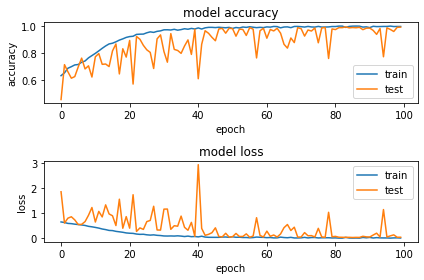

In [17]:
plot_metrics(history)

In [18]:
loss_and_metrics = model.evaluate(train_generator, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

640/640 - 49s - loss: 0.0040 - accuracy: 0.9973
Test Loss 0.003961245995014906
Test Accuracy 0.997265636920929


In [20]:
import time
t0= time.process_time()
y_pred_sm = model.predict(val_generator)
t1 = time.process_time() - t0
print("Time elapsed: ", t1, " seconds")

y_pred = np.argmax(y_pred_sm, axis=1)

Time elapsed:  15.928788224999153  seconds
